In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [155]:
# 1. Leitura e análise inicial dos dados
# Ler o arquivo Excel diretamente
dados = pd.read_excel('dados_rio_e_chuva.xlsx')

# Substituir vírgulas por pontos nos valores numéricos, se necessário
for col in dados.columns:
    if dados[col].dtype == 'object':
        try:
            dados[col] = dados[col].str.replace(',', '.').astype(float)
        except (ValueError, AttributeError):
            pass

print("Primeiras linhas do dataset:")
print(dados.head())
print(f"\nShape do dataset: {dados.shape}")
print("\nNomes das colunas:")
print(dados.columns.tolist())
print("\nTipos de dados:")
print(dados.dtypes)

# Verificar valores faltantes
print("\nValores faltantes por coluna:")
print(dados.isnull().sum())

# Remover duplicatas
dados = dados.drop_duplicates()
print(f"\nShape após remover duplicatas: {dados.shape}")


Primeiras linhas do dataset:
   NivelRiodoSul  NivelItuporanga  ChuvaItuporanaga  NivelTaio  ChuvaTaio
0            170               30               3.0         98        0.0
1            170               39              12.0         98        0.0
2            169               59              19.0         98        0.0
3            169               82               5.0         98        0.0
4            169               27               1.0         97        0.0

Shape do dataset: (65408, 5)

Nomes das colunas:
['NivelRiodoSul', 'NivelItuporanga', 'ChuvaItuporanaga', 'NivelTaio', 'ChuvaTaio']

Tipos de dados:
NivelRiodoSul         int64
NivelItuporanga       int64
ChuvaItuporanaga    float64
NivelTaio             int64
ChuvaTaio           float64
dtype: object

Valores faltantes por coluna:
NivelRiodoSul       0
NivelItuporanga     0
ChuvaItuporanaga    0
NivelTaio           0
ChuvaTaio           0
dtype: int64

Shape após remover duplicatas: (40277, 5)


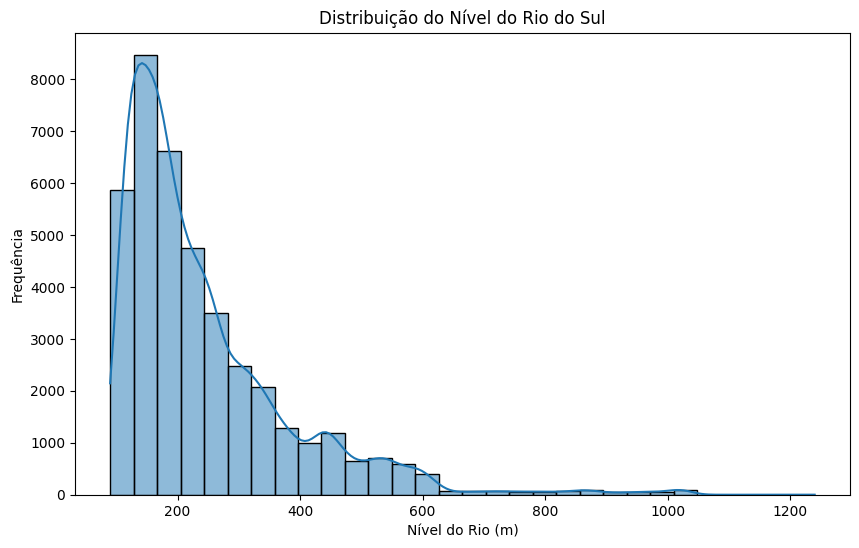

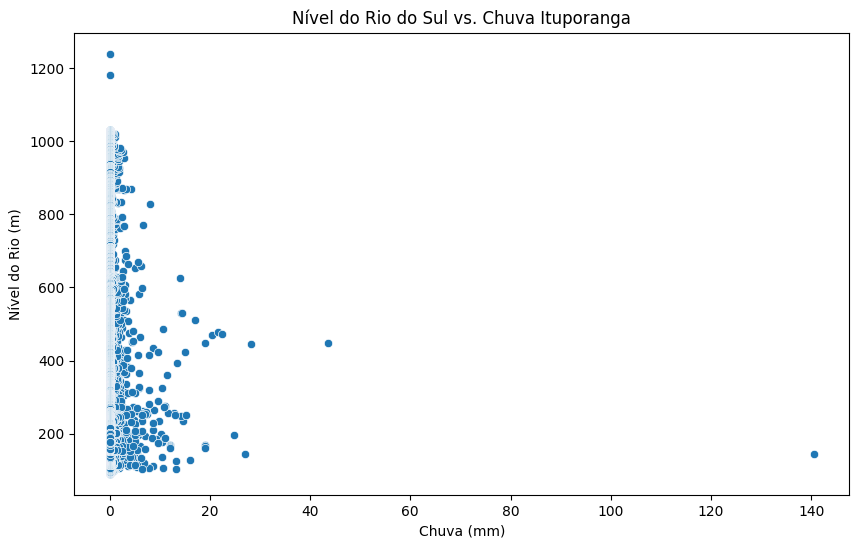

In [156]:
# Análise exploratória
# Histograma da variável alvo
plt.figure(figsize=(10, 6))
sns.histplot(dados['NivelRiodoSul'], bins=30, kde=True)
plt.title('Distribuição do Nível do Rio do Sul')
plt.xlabel('Nível do Rio (m)')
plt.ylabel('Frequência')
plt.show()

# Scatter plot como gráfico adicional
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ChuvaItuporanaga', y='NivelRiodoSul', data=dados)
plt.title('Nível do Rio do Sul vs. Chuva Ituporanga')
plt.xlabel('Chuva (mm)')
plt.ylabel('Nível do Rio (m)')
plt.show()


In [ ]:
# 2. Pré-processamento
# Seleção de features com base na correlação
correlacoes = dados.corr()['NivelRiodoSul'].abs().sort_values(ascending=False)
features_selecionadas = correlacoes[1:5].index.tolist()  
print("Features selecionadas:", features_selecionadas)
features_selecionadas = sorted(features_selecionadas)
print("Features selecionadas (ordenadas):", features_selecionadas)

for feature in features_selecionadas + ['NivelRiodoSul']:
    if feature.startswith('Nivel'):
        dados[feature] = dados[feature] / 100  

X = dados[features_selecionadas]
y = dados['NivelRiodoSul']

# Tratar valores faltantes
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Normalizar variáveis de entrada com MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

Features selecionadas: ['NivelTaio', 'NivelItuporanga', 'ChuvaItuporanaga', 'ChuvaTaio']
Features selecionadas (ordenadas): ['ChuvaItuporanaga', 'ChuvaTaio', 'NivelItuporanga', 'NivelTaio']


In [158]:
# 3. Treinamento do modelo com diferentes combinações
from itertools import combinations

best_score = -np.inf
best_features = []
best_scaler = None

for r in range(1, len(features_selecionadas) + 1):
    for combo in combinations(features_selecionadas, r):
        X_sub = dados[list(combo)]
        print(f"Intervalos para {list(combo)}: min={X_sub.min().min()}, max={X_sub.max().max()}")  # Verificar escala
        X_sub = X_sub.fillna(X_sub.mean())
        X_train_sub, X_test_sub, y_train, y_test = train_test_split(X_sub, y, test_size=0.3, random_state=42)
        
        scaler_sub = MinMaxScaler()
        X_train_scaled = scaler_sub.fit_transform(X_train_sub)
        X_test_scaled = scaler_sub.transform(X_test_sub)
        
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        score = model.score(X_test_scaled, y_test)
        
        print(f"Combinação {list(combo)} - R²: {score:.4f}")
        
        if score > best_score:
            best_score = score
            best_features = combo
            best_scaler = scaler_sub

print(f"\nMelhores features: {list(best_features)} com R²: {best_score:.4f}")

# Treinar o modelo final
X_best = dados[list(best_features)]
X_best = X_best.fillna(X_best.mean())
X_train_best, X_test_best, y_train, y_test = train_test_split(X_best, y, test_size=0.3, random_state=42)
X_train_scaled_best = best_scaler.fit_transform(X_train_best)
X_test_scaled_best = best_scaler.transform(X_test_best)
model.fit(X_train_scaled_best, y_train)

# Avaliar o modelo final
y_pred = model.predict(X_test_scaled_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMétricas do modelo final:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"Previsões vs Reais: {y_pred[:5]} vs {y_test[:5].values}")  # Comparar primeiras 5 previsões

Intervalos para ['ChuvaItuporanaga']: min=0.0, max=140.6
Combinação ['ChuvaItuporanaga'] - R²: 0.0010
Intervalos para ['ChuvaTaio']: min=0.0, max=48.0
Combinação ['ChuvaTaio'] - R²: -0.0002
Intervalos para ['NivelItuporanga']: min=0.08, max=5.12
Combinação ['NivelItuporanga'] - R²: 0.8168
Intervalos para ['NivelTaio']: min=0.46, max=9.75
Combinação ['NivelTaio'] - R²: 0.8822
Intervalos para ['ChuvaItuporanaga', 'ChuvaTaio']: min=0.0, max=140.6
Combinação ['ChuvaItuporanaga', 'ChuvaTaio'] - R²: 0.0009
Intervalos para ['ChuvaItuporanaga', 'NivelItuporanga']: min=0.0, max=140.6
Combinação ['ChuvaItuporanaga', 'NivelItuporanga'] - R²: 0.8168
Intervalos para ['ChuvaItuporanaga', 'NivelTaio']: min=0.0, max=140.6
Combinação ['ChuvaItuporanaga', 'NivelTaio'] - R²: 0.8833
Intervalos para ['ChuvaTaio', 'NivelItuporanga']: min=0.0, max=48.0
Combinação ['ChuvaTaio', 'NivelItuporanga'] - R²: 0.8168
Intervalos para ['ChuvaTaio', 'NivelTaio']: min=0.0, max=48.0
Combinação ['ChuvaTaio', 'NivelTaio'] -

In [159]:
# 4. Salvar o modelo
best_features_no_accents = [feature.encode().decode('ascii', 'ignore') for feature in best_features]
joblib.dump(model, 'modelo_regressao_linear.pkl')
joblib.dump(best_scaler, 'scaler.pkl')
joblib.dump(best_features_no_accents, 'features.pkl')
print("Modelo, scaler e features salvos com sucesso!")
import pickle
with open('features.pkl', 'rb') as f:
    print("Features salvas:", pickle.load(f))

Modelo, scaler e features salvos com sucesso!
Features salvas: ['ChuvaItuporanaga', 'ChuvaTaio', 'NivelItuporanga', 'NivelTaio']


In [160]:
import pickle
with open('features.pkl', 'rb') as f:
    print("Features salvas:", pickle.load(f))

Features salvas: ['ChuvaItuporanaga', 'ChuvaTaio', 'NivelItuporanga', 'NivelTaio']


In [161]:
# 5. Aplicação
def prever_nivel_rio(dados_entrada):
    model_carregado = joblib.load('modelo_regressao_linear.pkl')
    scaler_carregado = joblib.load('scaler.pkl')  # Carregar scaler
    features_carregadas = joblib.load('features.pkl')  # Carregar features
    
    # Preencher ordered_input com todas as features_carregadas, usando 0 para valores ausentes
    ordered_input = {k: dados_entrada.get(k, 0.0) for k in sorted(features_carregadas)}
    print("Dados de entrada ordenados:", ordered_input)  # Log para depuração
    
    entrada = pd.DataFrame([ordered_input], columns=features_carregadas)
    entrada_scaled = scaler_carregado.transform(entrada)  # Usar transform(), NÃO fit_transform()
    
    previsao = model_carregado.predict(entrada_scaled)[0]
    return previsao

# Exemplo de uso
exemplo_entrada = {'NivelItuporanga': 4.0, 'NivelTaio': 6.0}  # Usar nomes sem acentos
previsao = prever_nivel_rio(exemplo_entrada)
print(f"\nExemplo de previsão: Nível previsto do rio: {previsao:.2f} metros")

Dados de entrada ordenados: {'ChuvaItuporanaga': 0.0, 'ChuvaTaio': 0.0, 'NivelItuporanga': 4.0, 'NivelTaio': 6.0}

Exemplo de previsão: Nível previsto do rio: 8.83 metros
